# Cephalo: Instruction fine-tune example for stress and potential energy field statistics

```
@article{Buehler_Cephalo_2024,
  title={Cephalo: Multi-Modal Vision-Language Models for Bio-Inspired Materials Analysis and Design},
  author={Markus J. Buehler},
  journal={arXiv preprint arXiv:2405.19076},
  year={2024}
}
```

In [1]:
import os
#If you want to limit visible CUDA devices
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random
import io
import requests
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image as PILImage
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm
from io import BytesIO
import base64
import datetime
import seaborn as sns

from datasets import Dataset, DatasetDict, Features, Value, load_dataset, concatenate_datasets
from datasets import Image as DatasetsImage

from IPython.display import display, Image, HTML, Markdown

from huggingface_hub import HfFolder, HfApi

from transformers import (
    AutoProcessor, AutoModelForCausalLM, AutoTokenizer, AutoModelForVision2Seq, TrainerCallback,
    TrainingArguments, Trainer
)
from transformers.image_utils import load_image

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, PeftModel

from textwrap import wrap
import math

import torch

### Training parameters

In [2]:
# Define CUDA device
DEVICE='cuda:0'

# Define base model to start from
base_model_id='lamm-mit/Cephalo-Phi-3-vision-128k-4b-beta'

# Define output directories and file names
output_dir = 'Cephalo_stress-statistics_predict'
FT_model_name = output_dir
loss_file = output_dir + '.csv'

# Training hyperparameters
num_train_epochs = 4
gradient_accumulation_steps = 4
learning_rate = 1e-5
max_grad_norm = 0.5
lr_scheduler_type = "cosine"
optim = "paged_adamw_8bit"
push_model_to_hub = False

# Additional configuration
warmup_ratio = 0.01

# Number of samples to use for training (set to None to use all)
N_training_samples_select = 'all' # Use all
#N_training_samples_select = 512

### Define helper functions and tools

In [3]:
# Function to count model parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1e9, trainable_params / 1e9


# Function to check if a string is a URL
def is_url(val) -> bool:
    return isinstance(val, str) and val.startswith("http")


# Function to convert PIL image to base64 string
def pil_to_base64_str(img):
    img_buffer = io.BytesIO()
    img.save(img_buffer, format='PNG')
    img_str = base64.b64encode(img_buffer.getvalue()).decode('utf-8')
    return img_str


# Function to ensure an object is a list
def ensure_list(obj):
    if not isinstance(obj, list):
        return [obj]
    return obj


# Function to handle image-based question answering
def ask_about_image(model, processor, question, images_input=[], verbatim=False, temperature=0.1, show_image=False,
                    system="You are a scientist who responds accurately.", init_instr="", show_conversation=True,
                    max_new_tokens=256, messages=[], images=[], use_Markdown=False):

    query = question
    images_input = ensure_list(images_input)
    if not images:
        if images_input:
            for image in images_input:
                if is_url(image):
                    image = load_image(image)
                images.append(image)
                if show_image:
                    display(image)

    if not messages:
        image_messages = ''.join([f'<|image_{ii+1}|>' for ii, _ in enumerate(images_input)]) + '\n'
        messages = [{"role": "user", "content": f'{image_messages}\n{system}{init_instr}{query}'}]
    else:
        messages.append({"role": "user", "content": query})

    if verbatim:
        print(messages)

    text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=text, images=images, return_tensors="pt").to(DEVICE)

    generation_args = {
        "max_new_tokens": max_new_tokens,
        "temperature": temperature,
        "do_sample": True,
        "stop_strings": ['<|end|>','<|endoftext|>'],
        "tokenizer": processor.tokenizer,
    }
 
    generate_ids = model.generate(**inputs, **generation_args)
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    generated_texts = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    messages.append({"role": "assistant", "content": generated_texts})
    formatted_conversation = format_conversation(messages, images)

    if show_conversation:
        display(Markdown(formatted_conversation) if use_Markdown else HTML(formatted_conversation))

    return generated_texts, messages, images


# Function to format the conversation with images
def format_conversation(convo, images=[]):
    formatted = "<div style='display: grid; grid-template-columns: repeat(auto-fill, minmax(200px, 1fr)); gap: 10px;'>"
    for image in images:
        img_str = pil_to_base64_str(image)
        formatted += f"<div><img src='data:image/png;base64,{img_str}' width='100%'/></div>"
    formatted += "</div><br><br>"

    for entry in convo:
        role = entry['role']
        text = entry["content"].replace('\n', '<br>')
        formatted += f"<b>{role.capitalize()}:</b> {text}<br><br>"

    return formatted


# Function to convert prediction string to a vector
def prediction_to_vector(prediction):
    prediction = prediction.strip("[]")
    values = prediction.split(",")
    return np.array([float(value) for value in values])


# Function to plot ground truth vs predicted values
def plot_ground_truth_vs_predicted(test_dataset, model, processor, N_samples=None, show_conversation=False, temperature=0.01,
                                   labels=['stress_stdev', 'stress_mean', 'stress_median'], filter_term='CalculatePotentialEnergyStatistics',
                                   scatter_density=False):

    ground_truth_values = []
    predicted_values = []

    if N_samples is not None:
        test_dataset = test_dataset.select(range(N_samples))

    for example in tqdm(test_dataset):
        query = example['query']
        PIL_IMAGE = example['image']

        if filter_term in query:
            ground_truth = [example[item] for item in labels]

            ground_truth_values.append(ground_truth)

            response, _, _ = ask_about_image(model, processor, query, images_input=[PIL_IMAGE], show_image=False,
                                             temperature=temperature, system='', init_instr='',
                                             max_new_tokens=64, messages=[], images=[],
                                             show_conversation=False, use_Markdown=False)

            try:
                predicted = prediction_to_vector(response)
                predicted_values.append(predicted)
            except Exception as e:
                print(f"Error {e}")

    ground_truth_values = np.array(ground_truth_values)
    predicted_values = np.array(predicted_values)

    print (ground_truth_values.shape, predicted_values.shape)
    fig, axs = plt.subplots(len(labels), 1, figsize=(5, 5 * len(labels)))

    for i, ax in enumerate(axs.flat):
        if i < len(labels):
            gt_values = ground_truth_values[:, i]
            pred_values = predicted_values[:, i]

            # Calculate metrics
            r2 = r2_score(gt_values, pred_values)
            mae = mean_absolute_error(gt_values, pred_values)
            mse = mean_squared_error(gt_values, pred_values)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(gt_values, pred_values)

            # Print metrics
            print(f"{labels[i]} - R²: {r2:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")

            if scatter_density:
                sns.kdeplot(x=gt_values, y=pred_values, ax=ax, cmap='Reds', fill=True, alpha=0.5)
            # Scatter plot
            ax.scatter(gt_values, pred_values)
            ax.set_xlabel('Ground Truth')
            ax.set_ylabel('Predicted')
            ax.set_title(f"{labels[i]}")
            ax.plot([0, 1], [0, 1], 'k--', lw=2)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_aspect('equal')
            ax.text(0.05, 0.95, f'R² = {r2:.2f}', verticalalignment='top', horizontalalignment='left',
                    transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0))

    plt.tight_layout()

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"grid_plot_GT-v-pred_{timestamp}.svg"
    plt.savefig(filename)

    plt.show()


# Function to display images and text in a grid layout
def display_images_and_text(sampled_dataset, max_display=10):
    # Calculate the number of rows and columns for the grid
    cols = 3
    rows = math.ceil(max_display / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(13, rows * 4))
    axes = axes.flatten()

    for i, item in enumerate(sampled_dataset):
        if i >= len(axes) or i >= max_display:
            break
        
        # Display the image
        axes[i].imshow(item['image'])
        axes[i].axis('off')
        
        # Wrap the query and answer text
        query = "\n".join(wrap(f"Query: {item['query']}", 60))
        answer = "\n".join(wrap(f"Answer: {item['answer']}", 60))
        title_text = f"{query}\n\n{answer}"
        
        # Display the query and answer below the image
        axes[i].set_title(title_text, fontsize=10, pad=20)

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"loss_lot_{timestamp}.svg"
    plt.savefig(filename)
    
    plt.show()

### Load base model and the dataset

In [4]:
model = AutoModelForCausalLM.from_pretrained( base_model_id, torch_dtype=torch.bfloat16,
                                              _attn_implementation="flash_attention_2",
                                              trust_remote_code=True,
                                            ).to (DEVICE )

processor = AutoProcessor.from_pretrained( 
    base_model_id, trust_remote_code=True,
)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
#Only target layers in FF block (for downstream MoE construction)
target_modules=[
        "gate_up_proj",
        "down_proj", #add others if you want to use other linear layers for LoRA
     ]
lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        bias="none",
        lora_dropout=0.1,
        target_modules=target_modules,
        use_dora=False, 
        init_lora_weights="gaussian",
        task_type="CAUSAL_LM",
    )
model=get_peft_model(model, lora_config)

model.print_trainable_parameters()    

trainable params: 7,864,320 || all params: 4,154,485,760 || trainable%: 0.1893


### Prepare dataset: Create instructions and responses

In [6]:
def transform_example_stress(example):
    example["image"] = example.pop("microstructure")
    example["query"] = "CalculateVonMisesStressStatistics <stress_stdev, stress_mean, stress_median>"
    example["answer"] = f"[{example['stress_stdev']:.3f}, {example['stress_mean']:.3f}, {example['stress_median']:.3f}]"
    
    # Keep only the required fields
    keys_to_keep = ["image", "query", "answer"]
    
    return {key: example[key] for key in keys_to_keep}
     
def transform_example_energy(example):
    example["image"] = example.pop("microstructure")
    example["query"] = "CalculatePotentialEnergyStatistics <energy_peratom_std_dev, energy_peratom_mean, energy_peratom_median>"
    example["answer"] = f"[{example['energy_peratom_std_dev']:.3f}, {example['energy_peratom_mean']:.3f}, {example['energy_peratom_median']:.3f}]"
    
    # Keep only the required fields
    keys_to_keep = ["image", "query", "answer"]
    
    return {key: example[key] for key in keys_to_keep}

# Load the dataset
dataset_stress = load_dataset('lamm-mit/crack_stress_field_graphene_uniaxial_loading_x', 
                                    split="train",
                                   )
dataset_stress_transformed = dataset_stress.map(transform_example_stress)
dataset_energy_transformed = dataset_stress.map(transform_example_energy)

dataset_stress_transformed = concatenate_datasets([ dataset_stress_transformed,
                                                    dataset_energy_transformed,
                                     ])

# Split the dataset into 90% training and 10% test sets
dataset_stress_train_test_split = dataset_stress_transformed.train_test_split(test_size=0.1, seed=42)

# Access the train and test datasets
stress_dataset_train = dataset_stress_train_test_split['train']
stress_dataset_test = dataset_stress_train_test_split['test']

# Print the number of examples in each split to verify
print(f"Number of training examples: {len(stress_dataset_train)}")
print(f"Number of test examples: {len(stress_dataset_test)}")

Number of training examples: 3600
Number of test examples: 400


In [7]:
#In case multiple datasets need to be combined
train_dataset = concatenate_datasets([stress_dataset_train,  ])

# Define a function that checks if all fields in an entry are None
def remove_all_none_entries(example):
    keys_to_check=[ 'image', ]
    all_none = all(example[field] is None for field in keys_to_check )
    return not all_none   

# Filter the dataset using the defined function
train_dataset = train_dataset.filter(remove_all_none_entries)

# Training 

In [8]:
class push_callback(TrainerCallback):
    def on_save(self, args, state, control, **kwargs):

        try:
            
            
            print ("Step: ", state.global_step)
            
            if push_model_to_hub:
                print ("Pushing model to HF hub..." )
                
                processor.push_to_hub('lamm-mit/'+FT_model_name, ) 
                model.push_to_hub('lamm-mit/'+FT_model_name, )  
            
        except:
            print ("Push error...", state.global_step )
        
        try:
            # Create a DataFrame and save it to a CSV file
            df = pd.DataFrame(trainer.state.log_history)
            df.to_csv('./' + loss_file)
            
            # Create subplots
            fig, ax1 = plt.subplots(2, 1, figsize=(10, 10))
            
            # Plot training loss
            ax1[0].plot(df['step'], df['loss'], 'o-', label='Training loss')
            ax1[0].set_ylabel('Loss')
            ax1[0].set_xlabel('Step')
            ax1[0].legend()
            ax1[0].set_title('Training Loss Over Steps')
            
            # Plot learning rate
            ax1[1].plot(df['step'], df['learning_rate'], 'o-', label='LR')
            ax1[1].set_ylabel('LR')
            ax1[1].set_xlabel('Step')
            ax1[1].legend()
            ax1[1].set_title('Learning Rate Over Steps')
            
            # Adjust layout and show plot
            plt.tight_layout()

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"loss_lot_{timestamp}.svg"
            plt.savefig(filename)
    
            plt.show()
            
        except:
            print ("Loss and LR plotting failed.")

        try:
            
            plot_ground_truth_vs_predicted(stress_dataset_test, model, processor, N_samples= len (stress_dataset_test),
                                          labels = ['stress_stdev', 'stress_mean', 'stress_median',  ],
                                          filter_term='CalculateVonMisesStressStatistics'
                                          )
            plot_ground_truth_vs_predicted(stress_dataset_test, model, processor, N_samples= len (stress_dataset_test),
                                          labels = ['energy_peratom_std_dev', 'energy_peratom_mean', 'energy_peratom_median', ],
                                          filter_term='CalculatePotentialEnergyStatistics',
                                          )
            pass
        except:
            print ("Test data analysis failed.")


In [138]:
class CephaloDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        assert len (examples)==1, "Batch size must be 1."
        for example in examples:
            image = example["image"]
            question = example["query"] 
            answer = example["answer"]
            try:
                text=example["text"]
            except:
                text=None
                
            if text!=None:
                image=None
                batch = processor(text=text,  return_tensors="pt", padding=True
                         )
            if image!=None:
                messages = [ {
                            "role": "user",  "content": '<|image_1|>\n'+question},
                              {"role": "assistant", "content": f"{answer}"}, 
                            ]
                
                text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
                batch = processor(text=text, images=[image], return_tensors="pt", padding=True
                         )
        labels = batch["input_ids"].clone() 
        labels = torch.clamp(labels, min=0, )

        batch["labels"] = labels
        return batch

collator = CephaloDataCollator(processor)

In [139]:
N_training_samples_select = 128

if N_training_samples_select != 'all':
    sampled_dataset = train_dataset.shuffle(seed=42).select(range (N_training_samples_select) )
else:
    sampled_dataset = train_dataset.shuffle(seed=42).select(range (len (train_dataset)) )
print ( len (sampled_dataset) )

128


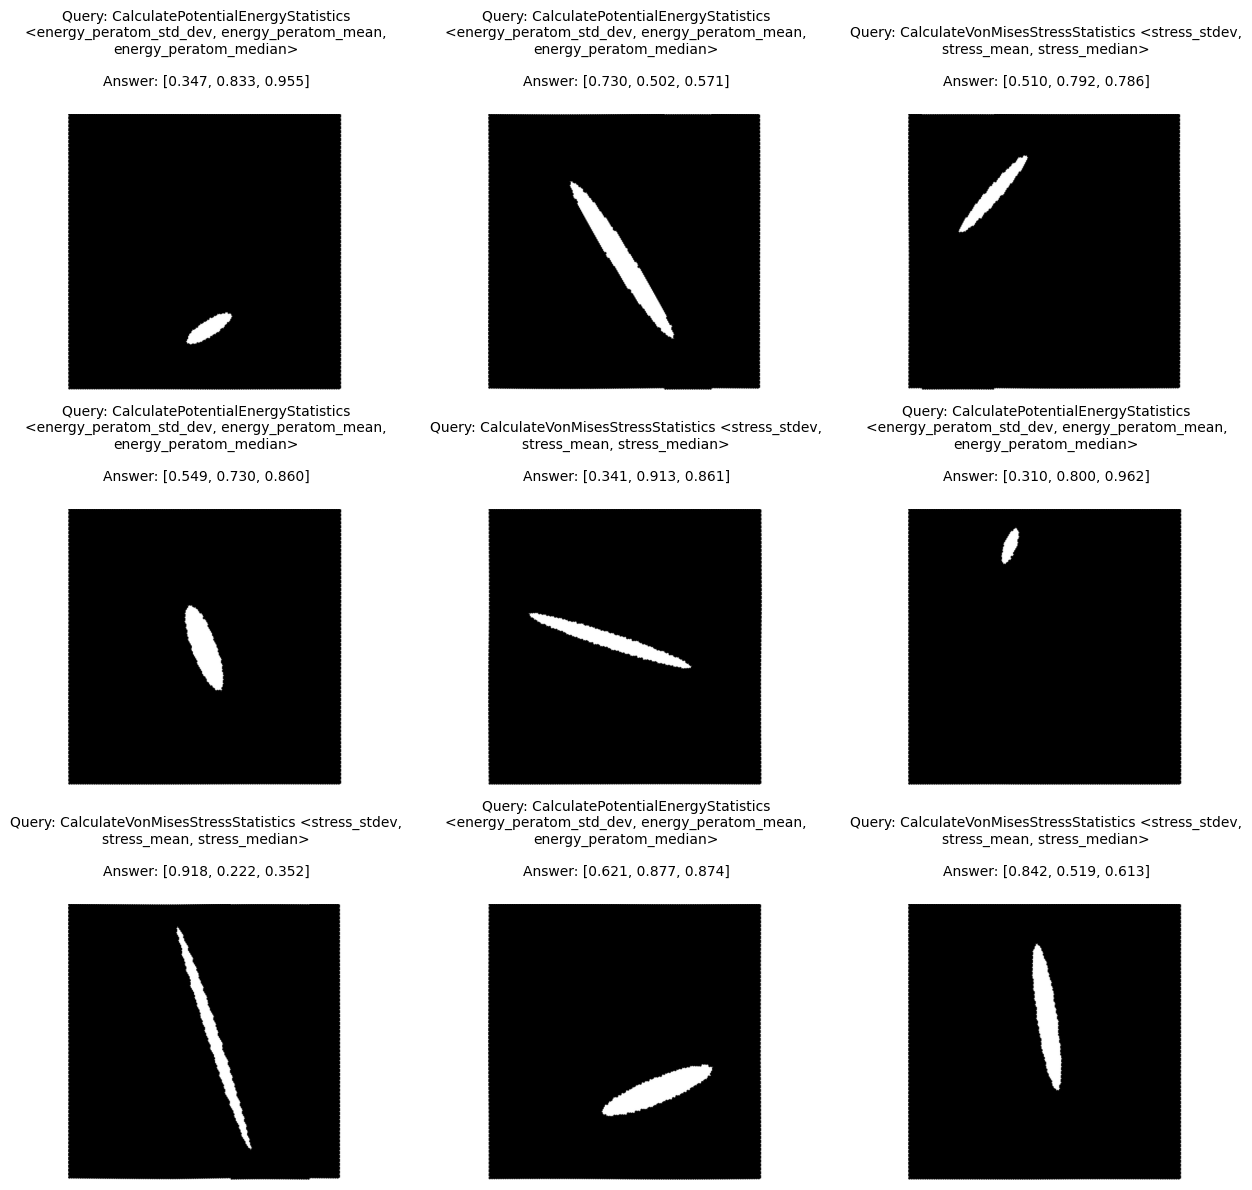

In [140]:
# Show samples of training set
display_images_and_text(sampled_dataset, max_display=9)

In [141]:
#only batch size of 1 supported
#     See also: 
#     https://github.com/microsoft/Phi-3CookBook/blob/main/code/04.Finetuning/vision_finetuning/finetune_hf_trainer_docvqa.py
per_device_train_batch_size = 1 

n_fragments=len (sampled_dataset)

total_steps     = int (num_train_epochs*(int (n_fragments)//per_device_train_batch_size )/gradient_accumulation_steps)
steps_per_epoch = int (total_steps//num_train_epochs)
logging_steps   = steps_per_epoch

warmupsteps     = int (total_steps*warmup_ratio)

total_steps, steps_per_epoch, warmupsteps, n_fragments

training_args = TrainingArguments(
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,    
    max_grad_norm = max_grad_norm,
    optim=optim,
    warmup_steps=warmupsteps,
    learning_rate=learning_rate, 
    logging_steps=steps_per_epoch,
    output_dir=f"{FT_model_name}",
    save_steps=steps_per_epoch,
    lr_scheduler_type=lr_scheduler_type,    
    remove_unused_columns=False,
    report_to="none",
    save_total_limit=50,
    bf16=True, #check compute ability of your GPU 
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=sampled_dataset, 
    callbacks=[push_callback],
)

### Training  

In [ ]:
trainer.train()

### Load LoRA model from checkpoint

In [ ]:
DEVICE='cuda:0'
base_model_id='lamm-mit/Cephalo-Phi-3-vision-128k-4b-beta'

model = AutoModelForCausalLM.from_pretrained( base_model_id, torch_dtype=torch.bfloat16,
                                       #_attn_implementation="flash_attention_2",
                                             trust_remote_code=True,
                                                        ).to (DEVICE ) 

FT_checkpoint='Cephalo_stress-statistics_predict/checkpoint-7844'
model = PeftModel.from_pretrained(model, f"{FT_checkpoint}", )
processor = AutoProcessor.from_pretrained(base_model_id,  trust_remote_code=True,)

### Merge model, e.g. for later use in MoE model 

In [ ]:
safe_serialization=False #sert to False to save Phi-3-Vision model locally or push to hub (if True, use safetensors, not yet implemented)

merged_name=f'{FT_model_name}-merged'
model = model.merge_and_unload(progressbar=True) 

model.push_to_hub ('lamm-mit/'+merged_name, safe_serialization=safe_serialization)
processor.push_to_hub ('lamm-mit/'+merged_name, safe_serialization=safe_serialization)

model.save_pretrained (merged_name, safe_serialization=safe_serialization)
processor.save_pretrained (merged_name, safe_serialization=safe_serialization)

print ('lamm-mit/'+merged_name)

### Inference

In [ ]:
plot_ground_truth_vs_predicted(stress_dataset_test, model, processor, N_samples= len (stress_dataset_test),
                              labels = ['stress_stdev', 'stress_mean', 'stress_median',  ],
                              filter_term='CalculateVonMisesStressStatistics', scatter_density=True,
                              )
plot_ground_truth_vs_predicted(stress_dataset_test, model, processor, N_samples= len (stress_dataset_test),
                              labels = ['energy_peratom_std_dev', 'energy_peratom_mean', 'energy_peratom_median', ],
                              filter_term='CalculatePotentialEnergyStatistics', scatter_density=True,
                              )
